Final Project Submission <br>
Student name: Qilun Chen<br>
Student pace: full time<br>
Scheduled project review date/time: April/1/2022<br>
Instructor name: Praveen Gowtham, Joe Comeaux<br>
Blog post URL:https://github.com/nkbuddy/dsc-phase-4-project-Image-Classification-with-Deep-Learning

### Table of Contents
* [STEP 1: Define the Problem](#Define-the-Problem)
* [Step 2: Gather the Data](#Gather-the-Data)
* [Step 3: Prepare Data for Consumption](#Prepare-Data-for-Consumption)
    * [3.1 Import Libraries](#Import-Libraries)
        * [3.11 Load Data Modelling Libraries](#Load-Data-Modelling-Libraries)
    * [3.2 Meet and Greet Data](#Meet-and-Greet-Data)
        * [3.21 The 4 C's of Data Cleaning: Correcting, Completing, Creating, and Converting](#4C)
        * [3.22 Clean Data](#Clean-Data)
        * [3.23 Convert Formats](#Convert-Formats)
        * [3.24 Da-Double Check Cleaned Data](#Da-Double-Check-Cleaned-Data)
        * [3.25 Split Training and Testing Data](#Split-Training-and-Testing-Data)
* [Step 4: Perform Exploratory Analysis with Statistics](#Perform-Exploratory-Analysis-with-Statistics)
* [Step 5: Model Data](#Model-Data)
    * [5.1 Evaluate Model Performance](#Evaluate-Model-Performance)
        * [5.11 Model Performance with Cross-Validation (CV)](#CV)
        * [5.12 Tune Model with Hyper-Parameters](#Tune-Model-with-Hyper-Parameters)
        * [5.13 Tune Model with Feature Selection](#Tune-Model-with-Feature-Selection)
* [Step 6: Validate and Implement](#Validate-and-Implement)
* [STEP 7: Optimize and Strategize](#Optimize-and-Strategize)

# STEP 1: Define the Problem <a class="anchor" id="Define-the-Problem"></a>

Identifying whether or not they have pneumonia by Image-Based Deep Learning. Pneumonia is lungs with inflammatory, blackage of the bronchiole, and Alveoli with fluid. When interpreting the x-ray, the radiologist will look for white spots in the lungs (called infiltrates) that identify an infection.

# Step 2: Gather the Data <a class="anchor" id="Gather-the-Data"></a>

This dataset contains thousands of validated Chest X-Ray images  described. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 2 directories: Pneumonia, and NORMAL. The dataset is from Mendeley Data. University of California San Diego, Guangzhou Women and Children's Medical Center. The three contributors are Daniel Kermany, Kang Zhang, Michael Goldbaum.

# Step 3: Prepare Data for Consumption <a class="anchor" id="Prepare-Data-for-Consumption"></a>

## 3.1 Import Libraries <a class="anchor" id="Import-Libraries"></a>

In [71]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
!pip3 install pillow
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras import models
from keras import layers
from keras import optimizers
import seaborn as sns
from pathlib import Path

## 3.11 Load Data Modelling Libraries <a class="anchor" id="Load-Data-Modelling-Libraries"></a>

In [72]:
# Directory path
train_data_dir = '/Users/alanchan/Documents/Flatiron/dsc-phase-4-project-Image-Classification-with-Deep-Learning/data/chest_xray/train'
test_data_dir = '/Users/alanchan/Documents/Flatiron/dsc-phase-4-project-Image-Classification-with-Deep-Learning/data/chest_xray/test'
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = test_datagen.flow_from_directory(
        test_data_dir, 
        target_size=(150, 150),batch_size = 20,
        class_mode = 'binary')

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = train_datagen.flow_from_directory(
        train_data_dir, 
        target_size=(150,150),batch_size = 20,
        class_mode= 'binary')

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [73]:
test_generator.n

624

In [74]:
train_generator.n

5232

## 3.2 Meet and Greet Data <a class="anchor" id="Meet-and-Greet-Data"></a>

In [75]:
normal_cases_dir = Path(train_data_dir+"/NORMAL")
pneumonia_cases_dir = Path(train_data_dir+"/PNEUMONIA")
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data_df = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data_df.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data_df.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data_df = pd.DataFrame(train_data_df, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data_df = train_data_df.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data_df.head()

,image,label
0,/Users/alanchan/Documents/Flatiron/dsc-phase-4...,1
1,/Users/alanchan/Documents/Flatiron/dsc-phase-4...,1
2,/Users/alanchan/Documents/Flatiron/dsc-phase-4...,1
3,/Users/alanchan/Documents/Flatiron/dsc-phase-4...,1
4,/Users/alanchan/Documents/Flatiron/dsc-phase-4...,1


1    3883
0    1349
Name: label, dtype: int64


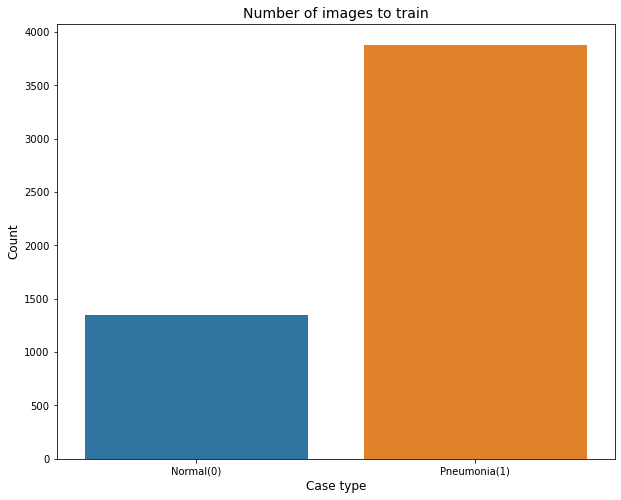

In [76]:
cases_count = train_data_df['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of images to train', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

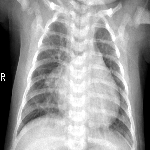

In [77]:
array_to_img(train_images[0])

In [78]:
train_images[0]

array([[[0.29803923, 0.29803923, 0.29803923],
        [0.31764707, 0.31764707, 0.31764707],
        [0.3137255 , 0.3137255 , 0.3137255 ],
        ...,
        [0.3529412 , 0.3529412 , 0.3529412 ],
        [0.27450982, 0.27450982, 0.27450982],
        [0.21960786, 0.21960786, 0.21960786]],

       [[0.30588236, 0.30588236, 0.30588236],
        [0.32941177, 0.32941177, 0.32941177],
        [0.32156864, 0.32156864, 0.32156864],
        ...,
        [0.34509805, 0.34509805, 0.34509805],
        [0.24313727, 0.24313727, 0.24313727],
        [0.24705884, 0.24705884, 0.24705884]],

       [[0.28627452, 0.28627452, 0.28627452],
        [0.31764707, 0.31764707, 0.31764707],
        [0.34509805, 0.34509805, 0.34509805],
        ...,
        [0.32941177, 0.32941177, 0.32941177],
        [0.22352943, 0.22352943, 0.22352943],
        [0.20784315, 0.20784315, 0.20784315]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [79]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(20, 150, 150, 3)
(20,)
(20, 150, 150, 3)
(20,)


In [80]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

# Step 5: Model Data <a class="anchor" id="Model-Data"></a>

In [81]:
from keras.preprocessing.image import ImageDataGenerator
import datetime

original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [53]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [54]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### 5.11 Model Performance with Cross-Validation (CV) <a class="anchor" id="CV"></a>

In [55]:
history = model.fit(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=test_generator, 
                              validation_steps=20)

Epoch 1/30
100/100 [==============================] - 65s 649ms/step - loss: 0.4759 - acc: 0.7826 - val_loss: 0.6766 - val_acc: 0.6350
Epoch 2/30
100/100 [==============================] - 66s 662ms/step - loss: 0.2734 - acc: 0.8830 - val_loss: 0.4916 - val_acc: 0.7750
Epoch 3/30
100/100 [==============================] - 60s 598ms/step - loss: 0.1828 - acc: 0.9262 - val_loss: 0.4010 - val_acc: 0.8350
Epoch 4/30
100/100 [==============================] - 63s 631ms/step - loss: 0.1356 - acc: 0.9430 - val_loss: 0.5450 - val_acc: 0.8150
Epoch 5/30
100/100 [==============================] - 57s 565ms/step - loss: 0.1254 - acc: 0.9520 - val_loss: 0.2959 - val_acc: 0.9025
Epoch 6/30
100/100 [==============================] - 60s 597ms/step - loss: 0.1101 - acc: 0.9550 - val_loss: 0.3988 - val_acc: 0.8625
Epoch 7/30
100/100 [==============================] - 62s 622ms/step - loss: 0.1089 - acc: 0.9608 - val_loss: 0.4621 - val_acc: 0.8425
Epoch 8/30
100/100 [==============================] - 7

# Step 6: Validate and Implement <a class="anchor" id="Validate-and-Implement"></a>

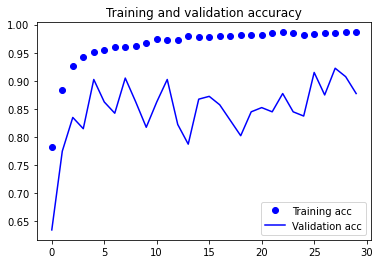

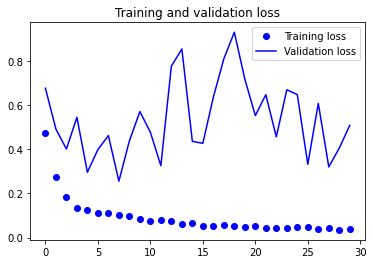

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [57]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))
test_loss, test_acc = model.evaluate(test_generator, steps=20)
print('test acc:', test_acc)

Training took a total of 1:32:45.973435


In [ ]:
model.save('image_classifier.model1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: image_classifier.model1/assets


In [ ]:
from keras.models import load_model
model = load_model('image_classifier.model1')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)     

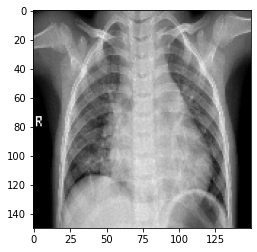

In [ ]:
from keras.preprocessing import image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

filename = 'data/chest_xray/test/PNEUMONIA/BACTERIA-40699-0002.jpeg'
img = image.load_img(filename, target_size=(150, 150))
plt.imshow(img)
plt.show()

(1, 150, 150, 3)


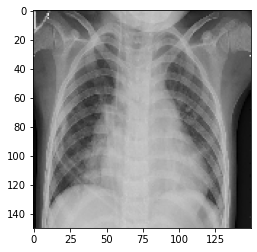

In [ ]:
import numpy as np

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# Follow the Original Model Preprocessing
img_tensor /= 255.

# Check tensor shape
print(img_tensor.shape)

# Preview an image
plt.imshow(img_tensor[0])
plt.show()

<ipython-input-150-938022819771>:40: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


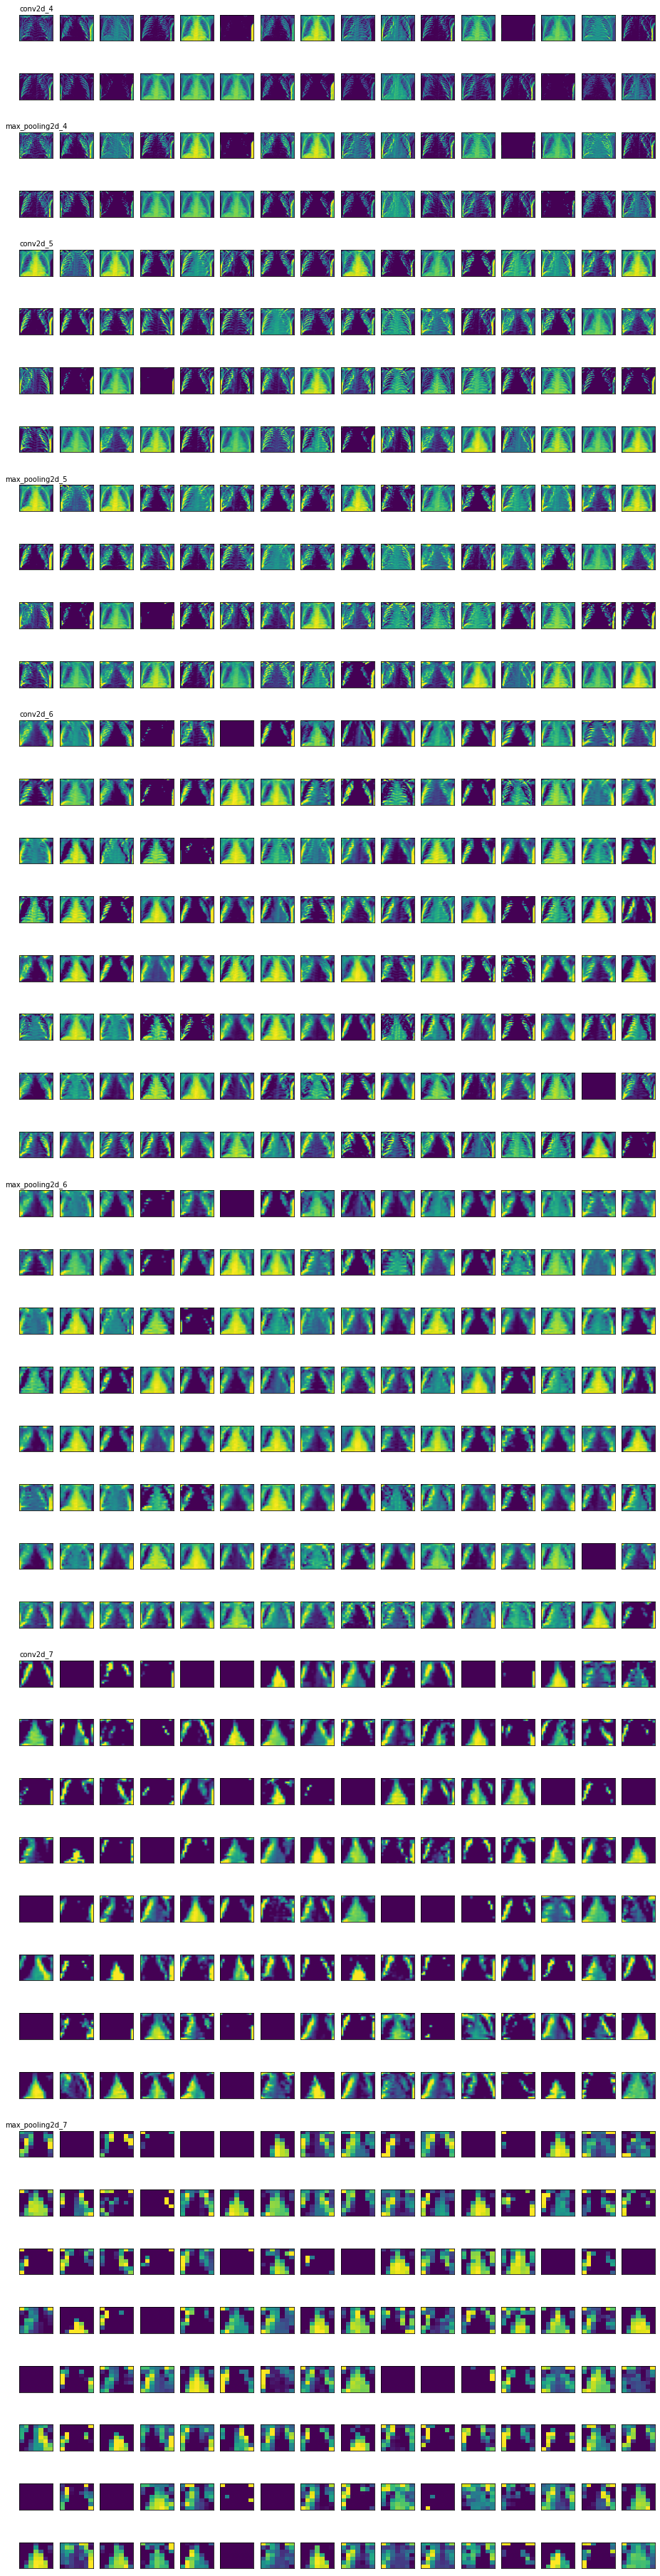

In [ ]:
from keras import models
import math 

# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Create a model for displaying the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

# Extract Layer Names for Labelling
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.savefig('Intermediate_Activations_Visualized.pdf')
plt.show()

### 5.12 Tune Model <a class="anchor" id="Tune-Model-with-Hyper-Parameters"></a>

5.121 second model

In [82]:
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense # creates densely connected layer object
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D # convolution layer
from tensorflow.keras.layers import MaxPooling2D # max pooling layer

In [92]:
model = Sequential()
# define 3x3 filter window sizes. Create 32 filters.
model.add(Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(150, 150, 3)))
# max pool in 2x2 window
model.add(MaxPooling2D(pool_size=(2, 2)))
# define 3x3 filter window sizes. Create 64 filters.
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

# transition to dense fully-connected part of network
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [94]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [95]:
history = model.fit(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=test_generator, 
                              validation_steps=20)

Epoch 1/30
100/100 [==============================] - 39s 393ms/step - loss: 0.4147 - acc: 0.8243 - val_loss: 0.4925 - val_acc: 0.7300
Epoch 2/30
100/100 [==============================] - 40s 396ms/step - loss: 0.2075 - acc: 0.9232 - val_loss: 0.4527 - val_acc: 0.8150
Epoch 3/30
100/100 [==============================] - 43s 426ms/step - loss: 0.1516 - acc: 0.9440 - val_loss: 0.5359 - val_acc: 0.7900
Epoch 4/30
100/100 [==============================] - 58s 583ms/step - loss: 0.1134 - acc: 0.9500 - val_loss: 0.4319 - val_acc: 0.8175
Epoch 5/30
100/100 [==============================] - 45s 455ms/step - loss: 0.1159 - acc: 0.9578 - val_loss: 0.3331 - val_acc: 0.8750
Epoch 6/30
100/100 [==============================] - 49s 486ms/step - loss: 0.1065 - acc: 0.9575 - val_loss: 0.6600 - val_acc: 0.7875
Epoch 7/30
100/100 [==============================] - 43s 426ms/step - loss: 0.0934 - acc: 0.9645 - val_loss: 0.6169 - val_acc: 0.8025
Epoch 8/30
100/100 [==============================] - 4

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=20)
print('test acc:', test_acc)

5.122 third model

In [98]:
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

In [102]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))

In [103]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [104]:
history = model.fit(train_generator, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_data=test_generator, 
                              validation_steps=20)

Epoch 1/30
100/100 [==============================] - 62s 615ms/step - loss: 0.2731 - acc: 0.9040 - val_loss: 0.7065 - val_acc: 0.4200
Epoch 2/30
100/100 [==============================] - 75s 747ms/step - loss: 0.1231 - acc: 0.9560 - val_loss: 0.8417 - val_acc: 0.6500
Epoch 3/30
100/100 [==============================] - 79s 792ms/step - loss: 0.1034 - acc: 0.9568 - val_loss: 1.8571 - val_acc: 0.6075
Epoch 4/30
100/100 [==============================] - 74s 741ms/step - loss: 0.0905 - acc: 0.9695 - val_loss: 2.8763 - val_acc: 0.6175
Epoch 5/30
100/100 [==============================] - 81s 809ms/step - loss: 0.0792 - acc: 0.9754 - val_loss: 2.5143 - val_acc: 0.6100
Epoch 6/30
100/100 [==============================] - 78s 779ms/step - loss: 0.0722 - acc: 0.9775 - val_loss: 0.6081 - val_acc: 0.8025
Epoch 7/30
100/100 [==============================] - 63s 633ms/step - loss: 0.0681 - acc: 0.9779 - val_loss: 1.9347 - val_acc: 0.7050
Epoch 8/30
100/100 [==============================] - 6

In [105]:
test_loss, test_acc = model.evaluate(test_generator, steps=20)
print('test acc:', test_acc)

20/20 [==============================] - 5s 235ms/step - loss: 0.7710 - acc: 0.8625
test acc: 0.862500011920929


# Step6: Validate and Implement<a class="anchor" id="Validate-and-Implement"></a>

In [111]:
val_generator = test_datagen.flow_from_directory(
        test_data_dir, 
        target_size=(150,150),batch_size = 500)

# Create the datasets
val_images, val_labels = next(val_generator)

Found 624 images belonging to 2 classes.


In [119]:
np.shape(val_images)

(500, 150, 150, 3)

In [124]:
preds = model.predict_classes(val_images)
preds = preds.reshape(1,-1)[0]

# Original labels
orig_test_labels = np.argmax(val_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)
print(val_labels.shape)

(500,)
(500,)
(500, 2)


In [125]:
np.sum(preds)

372

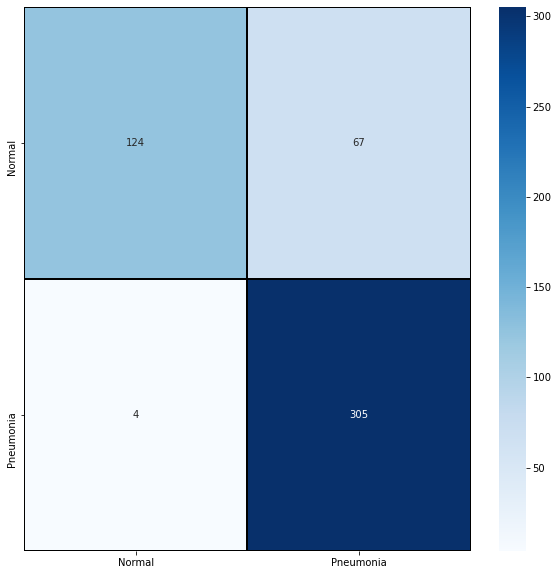

In [137]:

cm  = confusion_matrix(orig_test_labels, preds)
cm = pd.DataFrame(cm , index = ['Normal', 'Pneumonia'] , columns = ['Normal', 'Pneumonia'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='');

In [142]:
correct = np.nonzero(preds == val_labels)[0]
incorrect = np.nonzero(preds != val_labels)[0]

<ipython-input-142-39fca69a639f>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct = np.nonzero(preds == val_labels)[0]
<ipython-input-142-39fca69a639f>:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  incorrect = np.nonzero(preds != val_labels)[0]


In [147]:
preds[0]

1

In [148]:
orig_test_labels[0]

1

In [155]:
TP = []
TN = []
FP = []
FN = []
for i in range(len(preds)):
    if preds[i] == orig_test_labels[i] == 1:
        TP.append(i)
    elif preds[i] == orig_test_labels[i] == 0:
        TN.append(i)
    elif preds[i] ==1 and orig_test_labels[i] == 0:
        FN.append(i)
    elif preds[i] ==0 and orig_test_labels[i] == 1:
        FP.append(i)

In [162]:
print(len(TP))
print(len(TN))
print(len(FN))
print(len(FP))

305
124
67
4


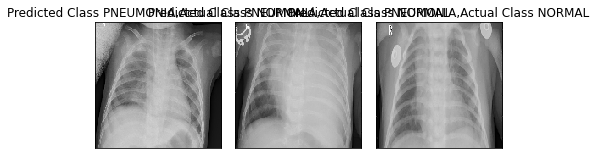

In [176]:
i = 0
for c in TP[:3]:
    plt.subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(val_images[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format("PNEUMONIA", 'NORMAL'))
    plt.tight_layout()
    i += 1

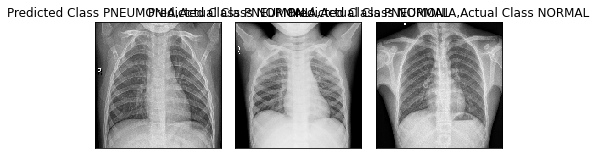

In [178]:
i = 0
for c in TN[:3]:
    plt.subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(val_images[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format("PNEUMONIA", 'NORMAL'))
    plt.tight_layout()
    i += 1

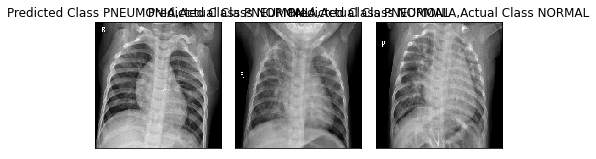

In [179]:
i = 0
for c in FP[:3]:
    plt.subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(val_images[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format("PNEUMONIA", 'NORMAL'))
    plt.tight_layout()
    i += 1

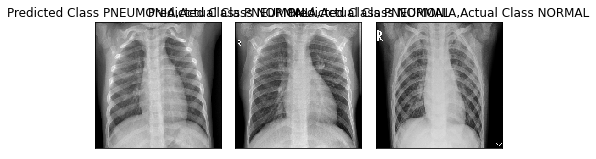

In [180]:
i = 0
for c in FN[:3]:
    plt.subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(val_images[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format("PNEUMONIA", 'NORMAL'))
    plt.tight_layout()
    i += 1

# Step 7: Optimize and Strategize<a class="anchor" id="Optimize-and-Strategize"></a>

We see that our accuracy on our test data is 86.5%. This may indicate overfitting. 
Our recall is greater than our precision, indicating that almost all pneumonia images are correctly identified but some normal images are falsely identified. We should aim to increase our precision.
